In [1]:
import numpy as np
import sys
import os
import pandas as pd

# Adjust the path to point to external/AlphaPEM
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.sampling.sampler import get_polarisation_curve_samples, build_fixed_parameters, sample_parameters, PARAMETER_RANGES



In [2]:
independent_params = {
    k: v for k, v in PARAMETER_RANGES.items()
    if k != "Pc_des"
}

# Add dummy variable for Pc_des dependency
independent_params["z_Pc"] = (0, 1)

problem = {
    "num_vars": len(independent_params),
    "names": list(independent_params.keys()),
    "bounds": [v if isinstance(v, tuple) else [min(v), max(v)] for v in independent_params.values()]
}

def make_bounds_exclusive(bounds, epsilon=1e-8):
    return [(low + epsilon, high - epsilon) for (low, high) in bounds]
problem["bounds"] = make_bounds_exclusive(problem["bounds"])


In [3]:
from SALib.sample import morris
import random

seed_value = 42
np.random.seed(seed_value)  # For NumPy
random.seed(seed_value)  # For random module

samples = morris.sample(problem, N=2, num_levels=4)
df_samples = pd.DataFrame(samples, columns=problem["names"])

# Compute Pc_des = max(1e, Pa_des - 0.5e5) + z * (max(1e, Pa_des - 0.1e5) - max(1e, Pa_des - 0.5e5)) Replace 1 with 101325 since Pc_des > Pext = 101325
Pa_des = df_samples["Pa_des"]
z = df_samples["z_Pc"]

low = np.maximum(101325, Pa_des - 0.5e5)
high = np.maximum(101325, Pa_des - 0.1e5)

df_samples["Pc_des"] = low + z * (high - low)

# Optional: Drop z_Pc after constructing Pc_des
df_samples = df_samples.drop(columns="z_Pc")

df_samples["e"] = df_samples["e"].round().clip(lower=3, upper=5)

In [7]:
sampled_parameters = df_samples.to_dict(orient="records")
fixed_parameters = build_fixed_parameters()

results = get_polarisation_curve_samples(sampled_parameters, fixed_parameters, save_every=5)

✅ Saved 5 samples to ../data/raw/results.csv
✅ Saved 10 samples to ../data/raw/results.csv
✅ Saved 15 samples to ../data/raw/results.csv
✅ Saved 20 samples to ../data/raw/results.csv
✅ Saved 25 samples to ../data/raw/results.csv
✅ Saved 30 samples to ../data/raw/results.csv
✅ Saved 35 samples to ../data/raw/results.csv
✅ Saved 40 samples to ../data/raw/results.csv

📁 Final save complete: ../data/raw/results.csv with 40 valid samples.


In [11]:
df_samples.to_csv('../data/raw/file.csv', index=False)

In [24]:
# Extract all Ucell arrays into a 2D numpy array (n_samples, n_outputs)
Y_all = np.stack(results["Ucell"].values)
n_outputs = Y_all.shape[1]

# Store sensitivity results for each output index
morris_all = []

for i in range(n_outputs):
    analysis = morris_analyze.analyze(
        problem=problem,
        X=df_samples.to_numpy(),
        Y=Y_all[:, i],
        conf_level=0.95,
        num_levels=4,
        print_to_console=False
    )
    morris_all.append({
        'mu_star': analysis['mu_star'],
        'sigma': analysis['sigma'],
        'param': problem['names'],
        'output_index': i
    })


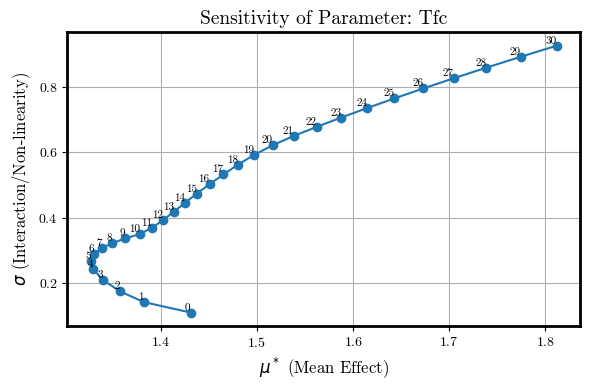

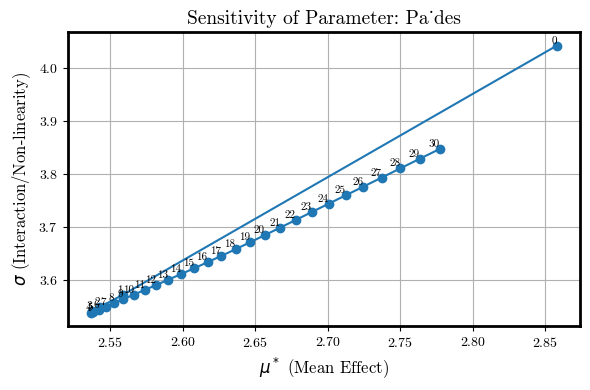

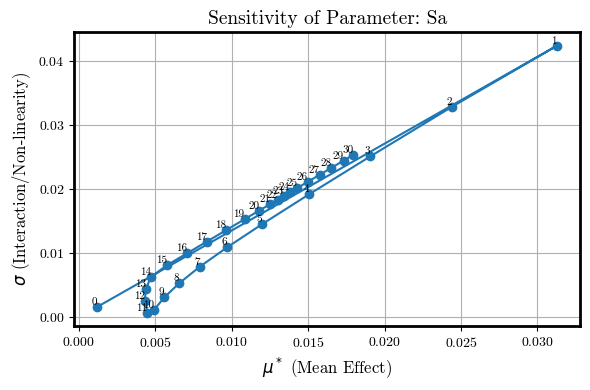

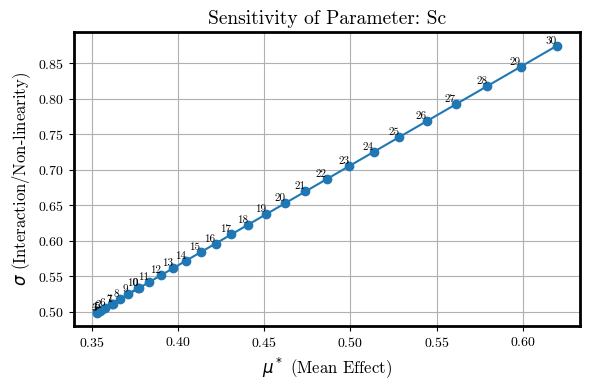

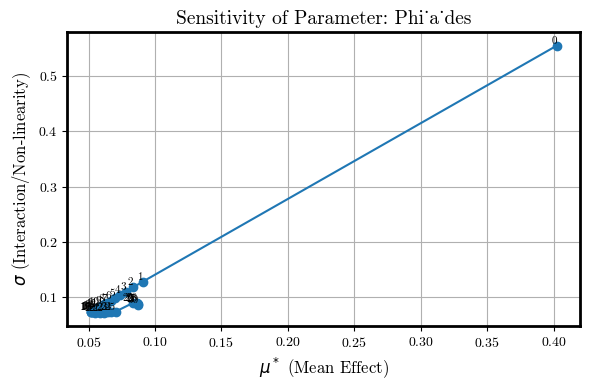

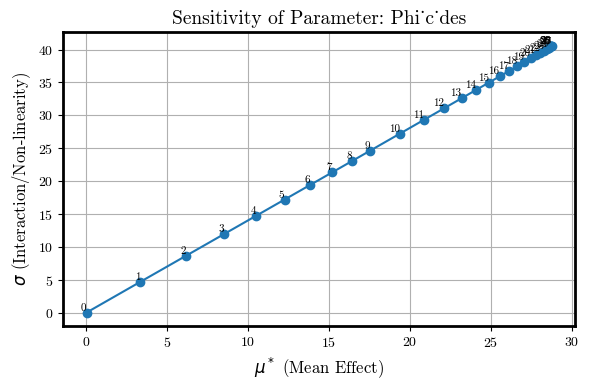

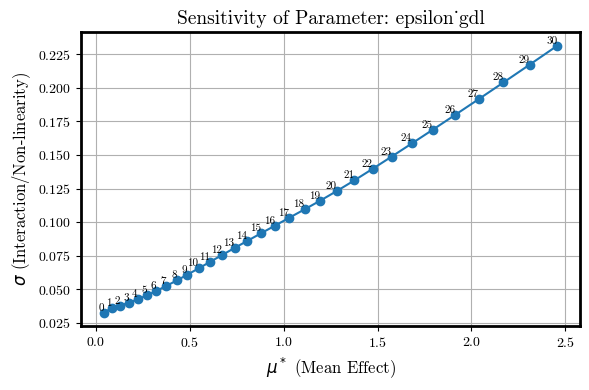

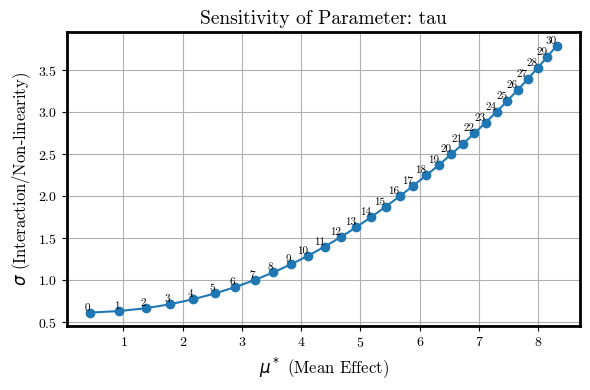

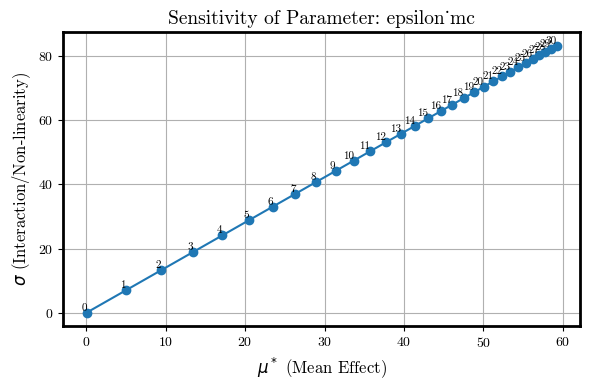

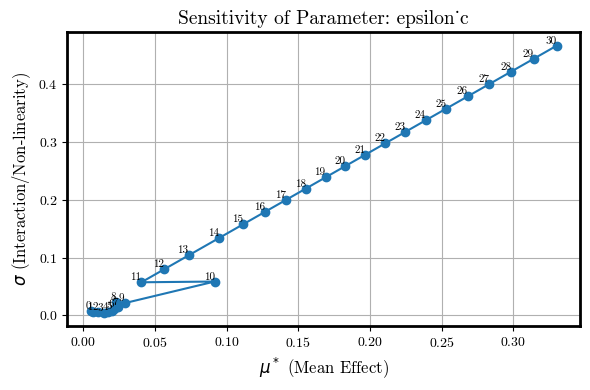

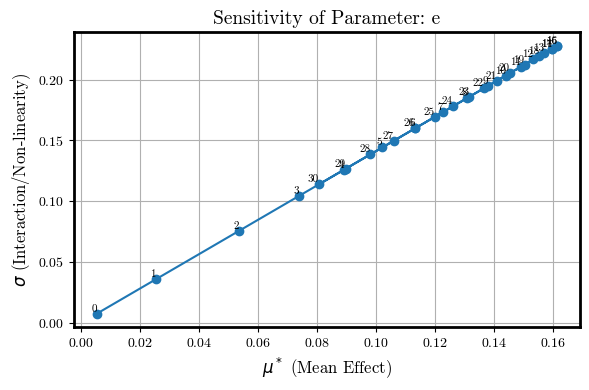

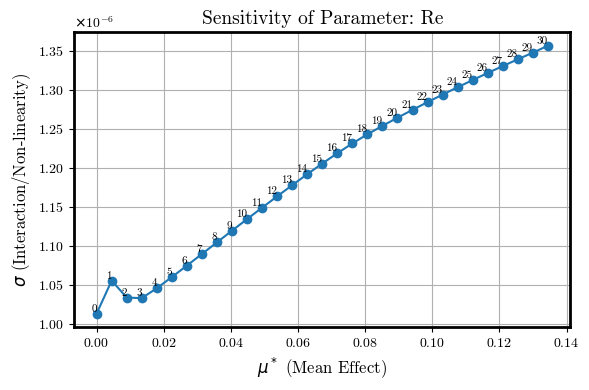

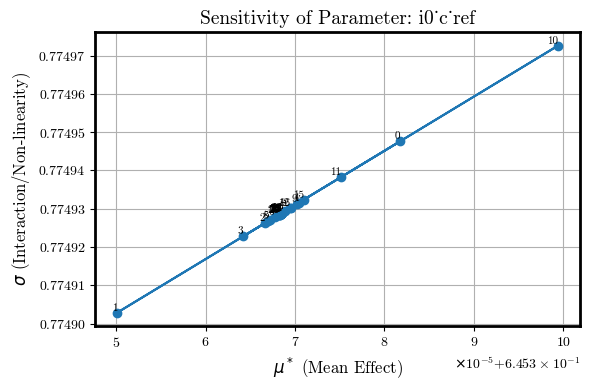

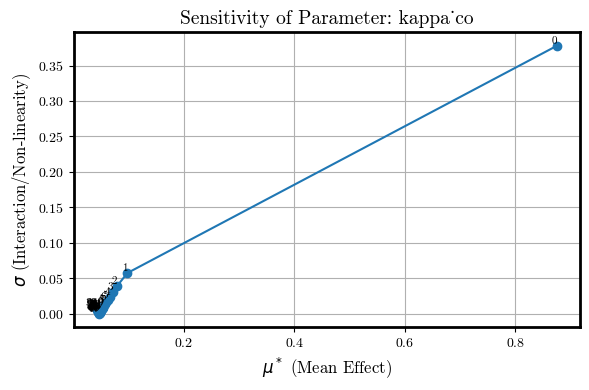

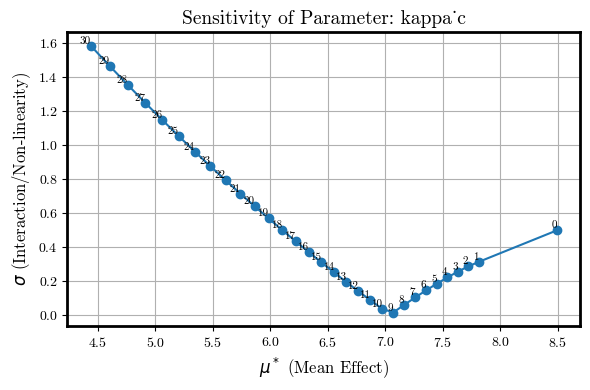

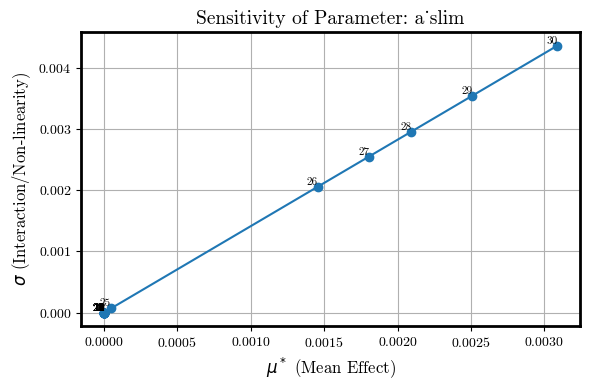

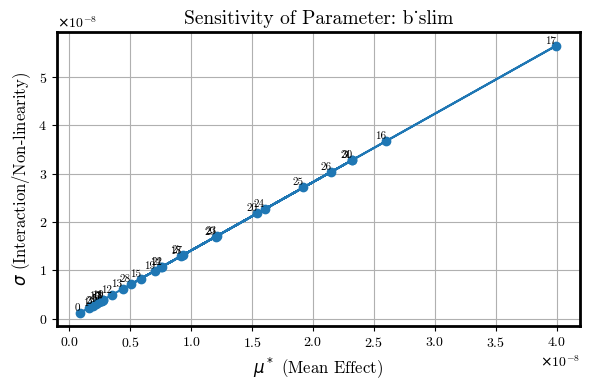

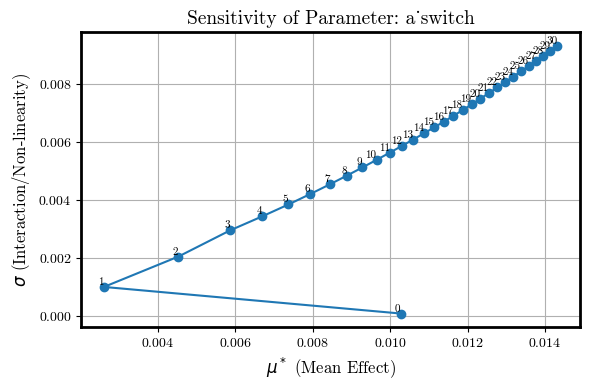

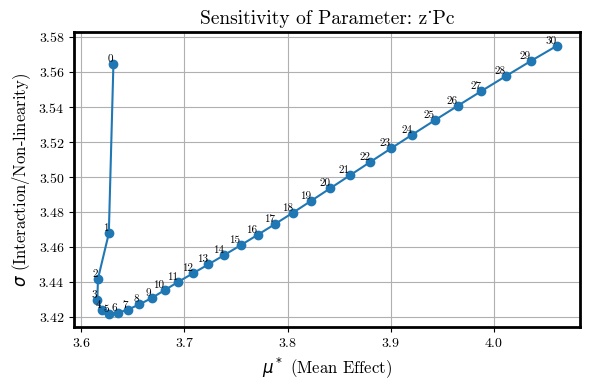

In [29]:
import matplotlib.pyplot as plt

params = problem['names']
n_params = len(params)
n_outputs = len(morris_all)

# Create one plot per parameter
for param_idx in range(n_params):
    mu_star_vals = []
    sigma_vals = []
    output_indices = []

    for output in morris_all:
        mu_star_vals.append(output['mu_star'][param_idx])
        sigma_vals.append(output['sigma'][param_idx])
        output_indices.append(output['output_index'])

    plt.figure(figsize=(6, 4))
    plt.plot(mu_star_vals, sigma_vals, marker='o', linestyle='-')
    for i, (mu, sigma) in enumerate(zip(mu_star_vals, sigma_vals)):
        plt.text(mu, sigma, str(output_indices[i]), fontsize=8, ha='right', va='bottom')

    plt.xlabel(r'$\mu^*$ (Mean Effect)', fontsize=12)
    plt.ylabel(r'$\sigma$ (Interaction/Non-linearity)', fontsize=12)
    plt.title(f'Sensitivity of Parameter: {params[param_idx]}', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\dejvi\AppData\Local\Temp\ipykernel_13280\1847060548.py:23: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\dejvi\AppData\Local\Temp\ipykernel_13280\1847060548.py:23: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) cmr10.
  plt.tight_layout()
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 963 (\N{GREEK SMALL LETTER SIGMA}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dejvi\Documents\GitHub\Sensitivity-Analysis-and-Surrogate-Modeling-of-PEM-Fuel-Cells\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 956 (\N{GREEK SMALL LETTER MU}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


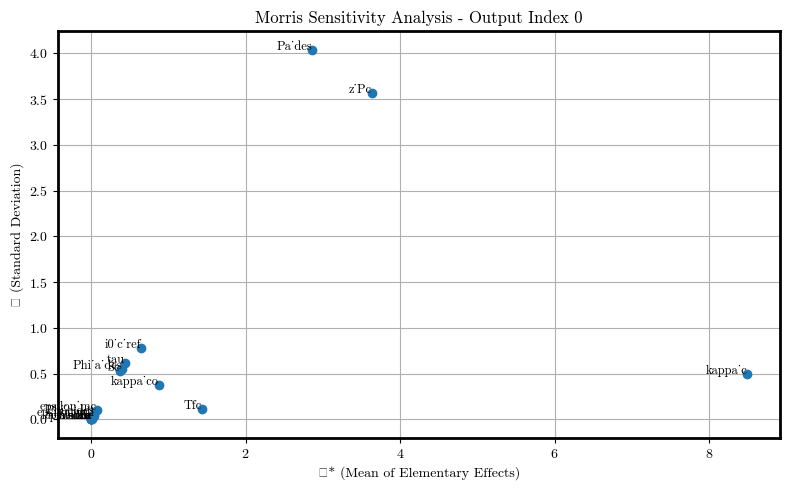

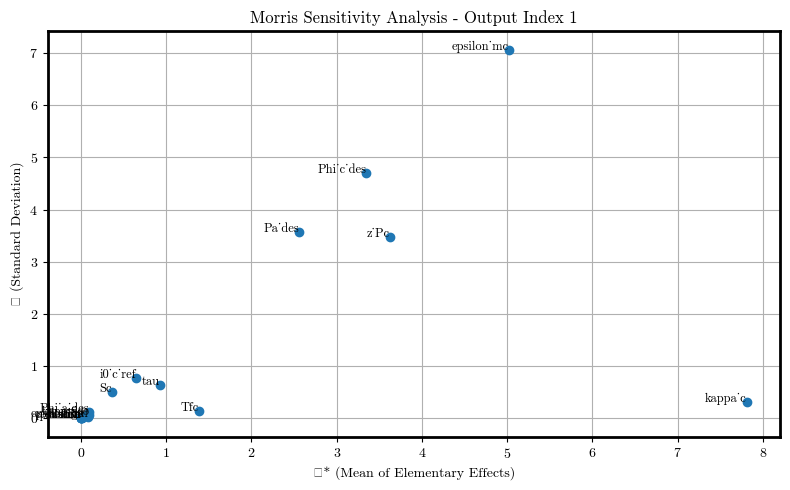

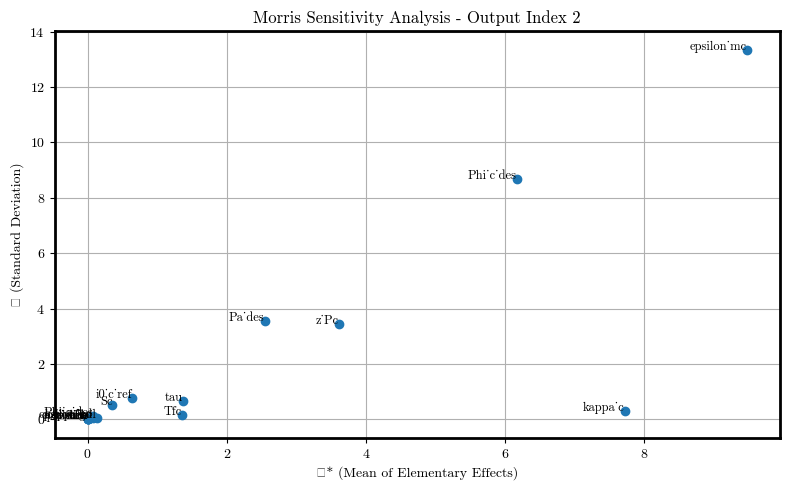

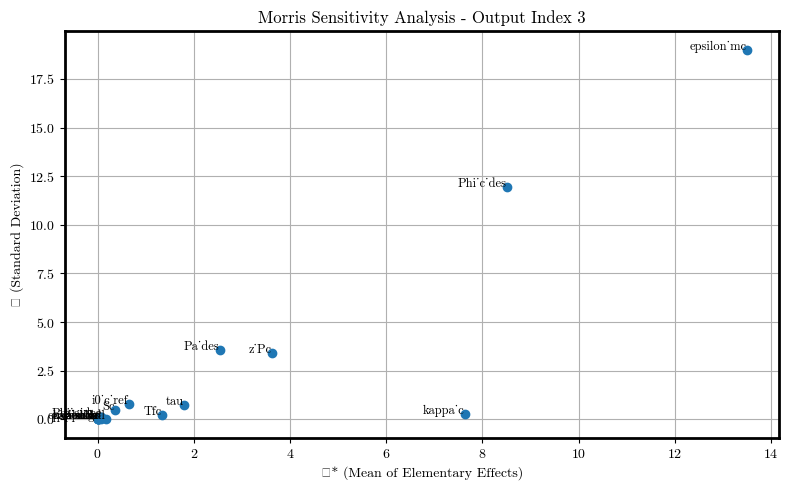

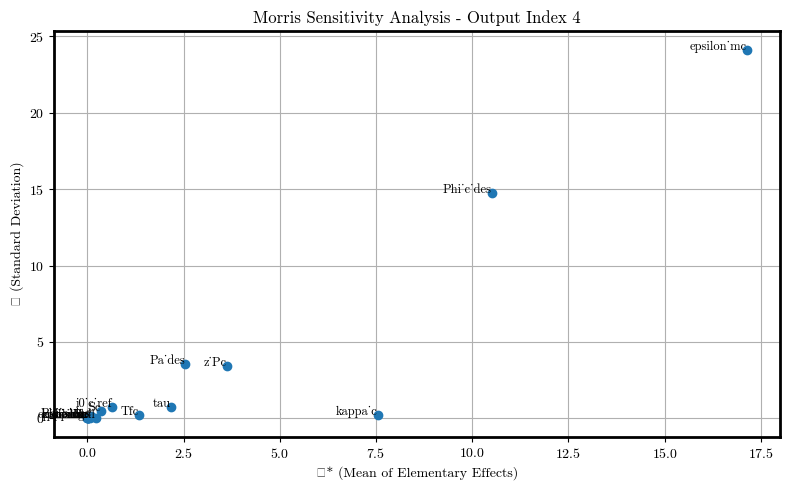

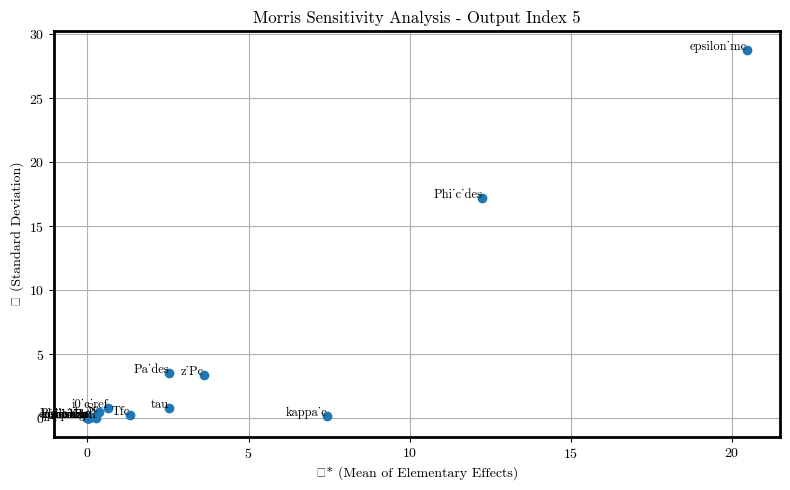

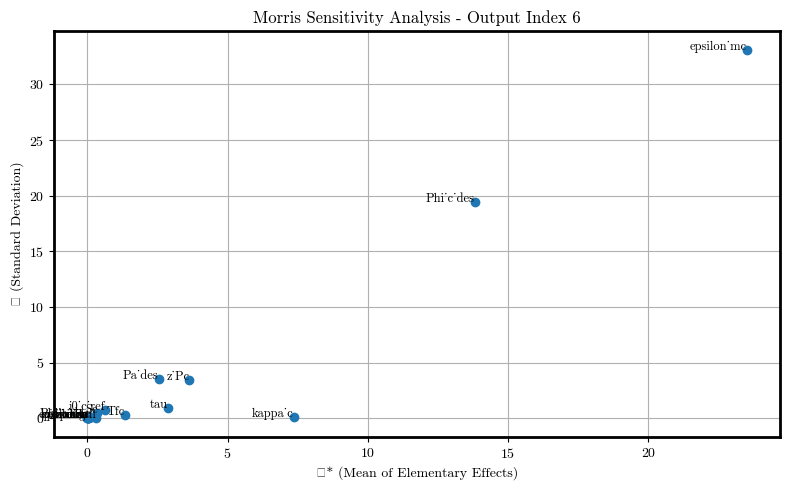

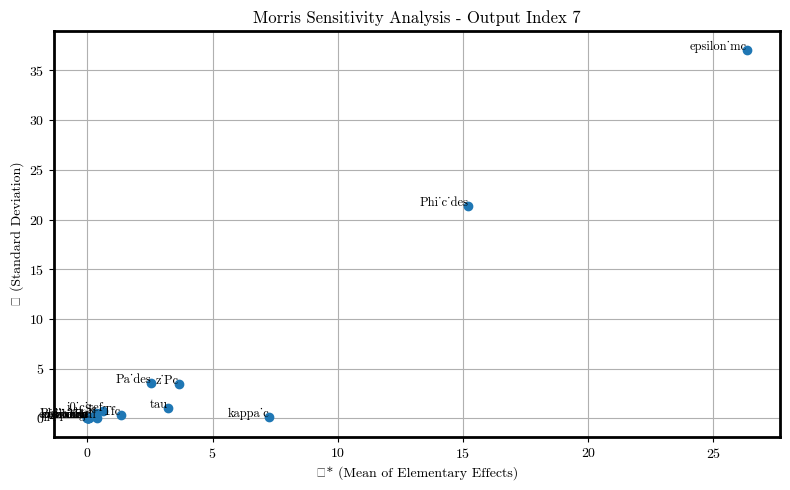

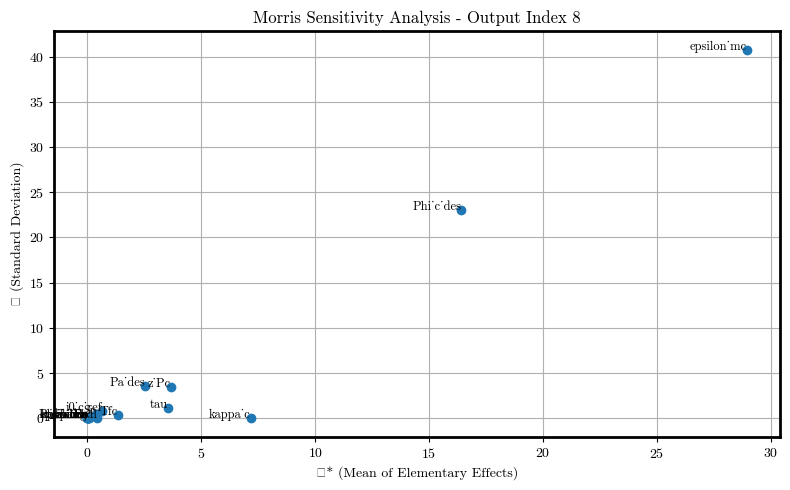

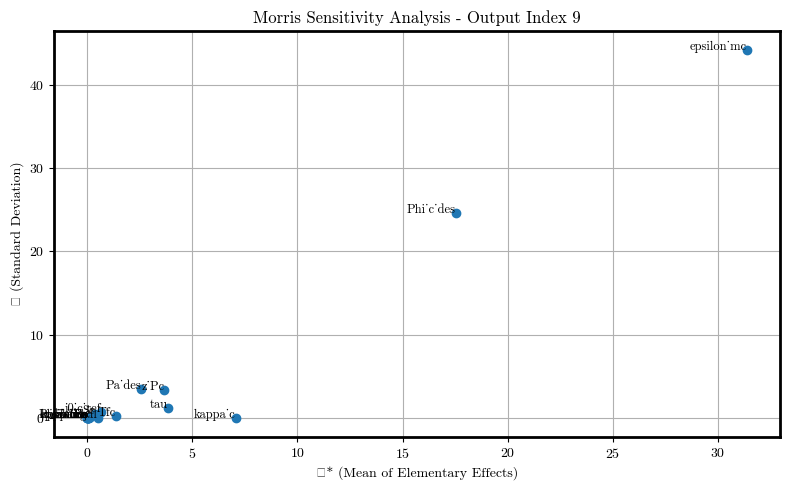

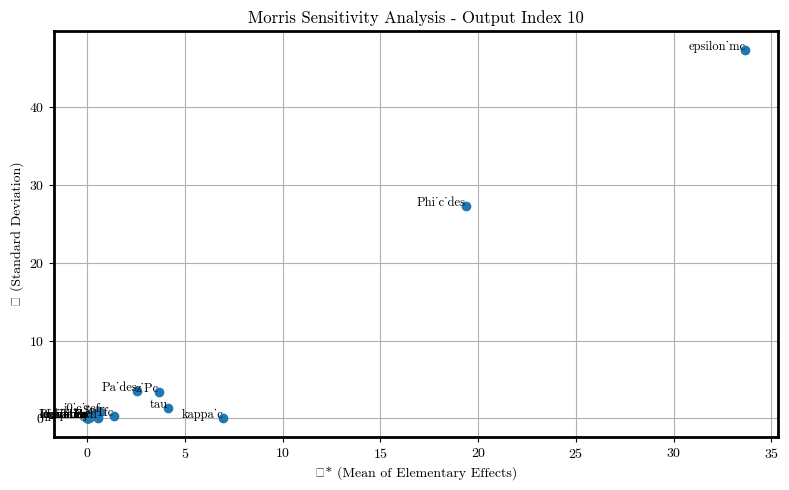

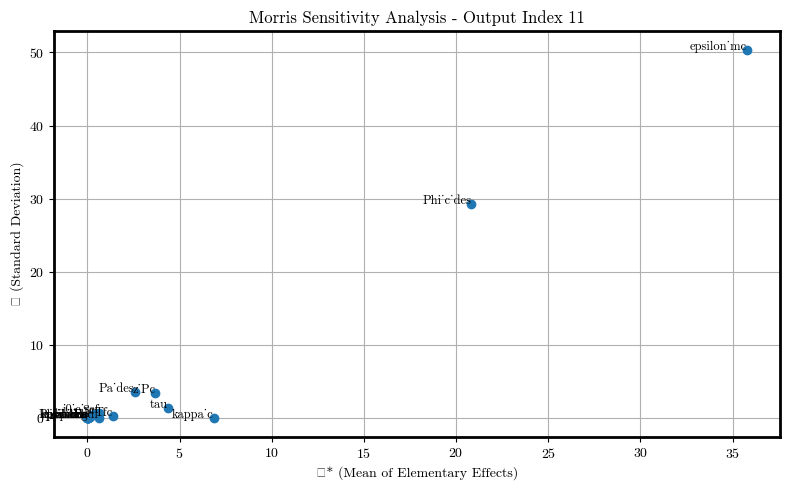

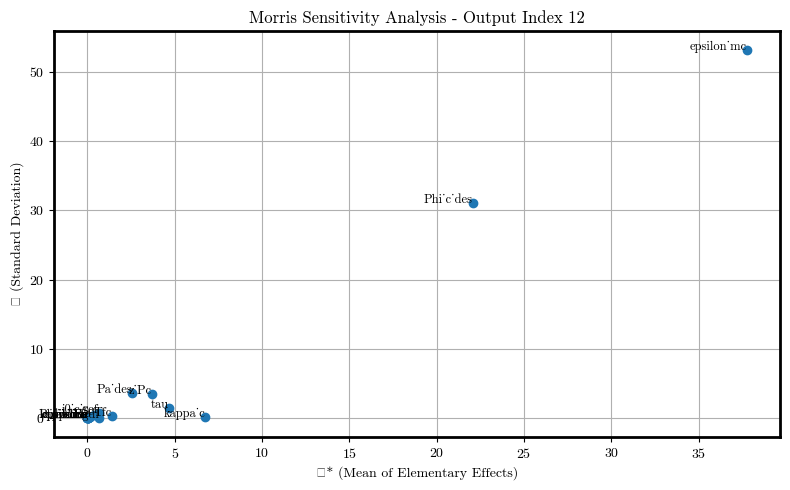

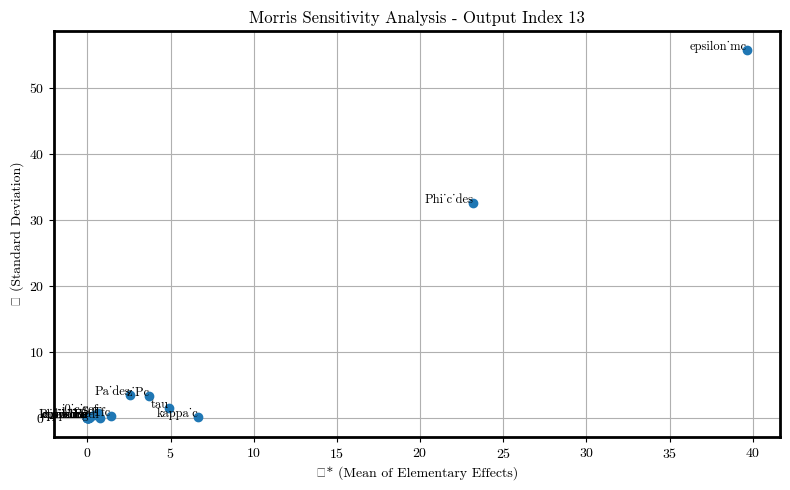

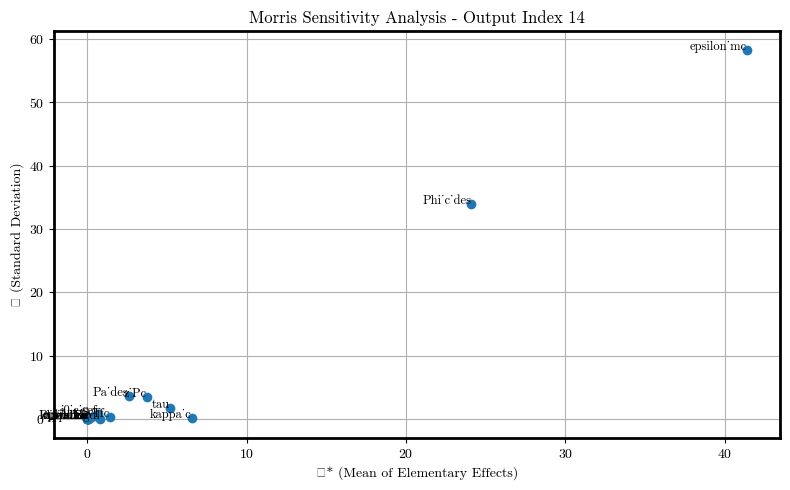

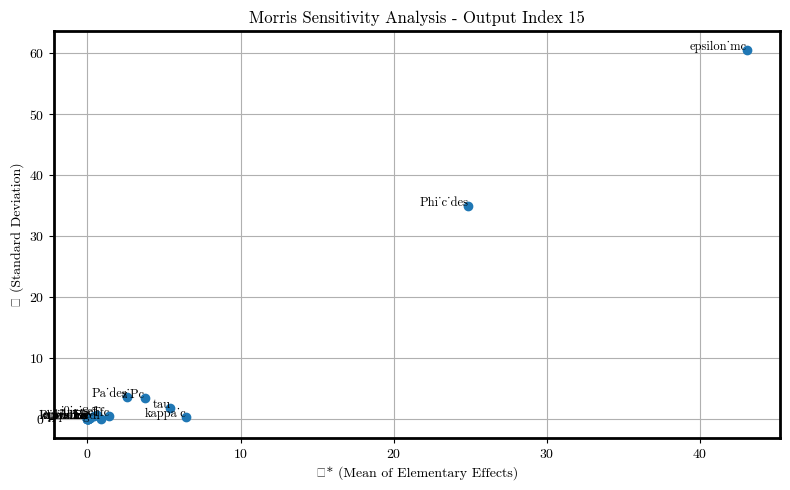

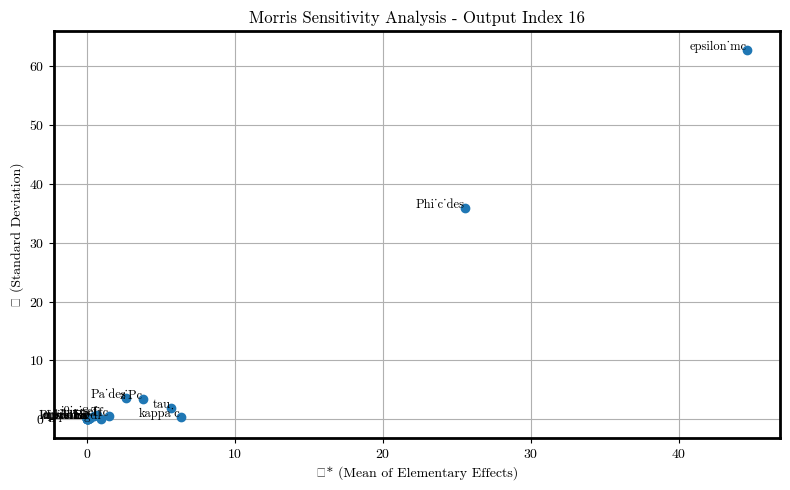

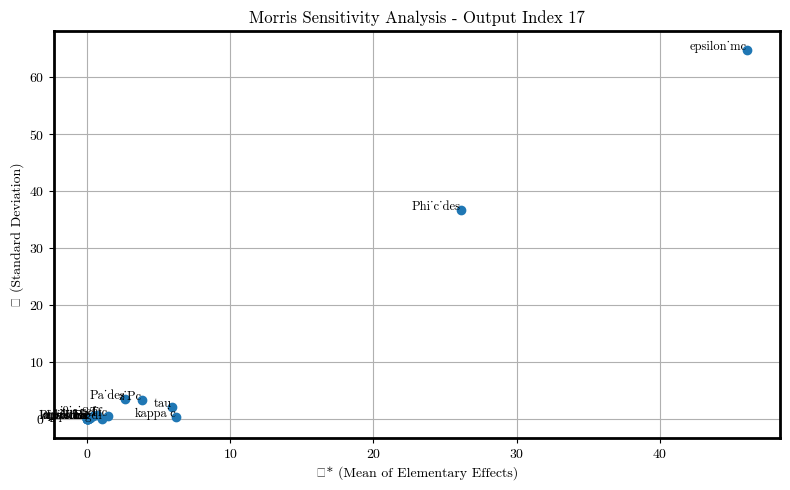

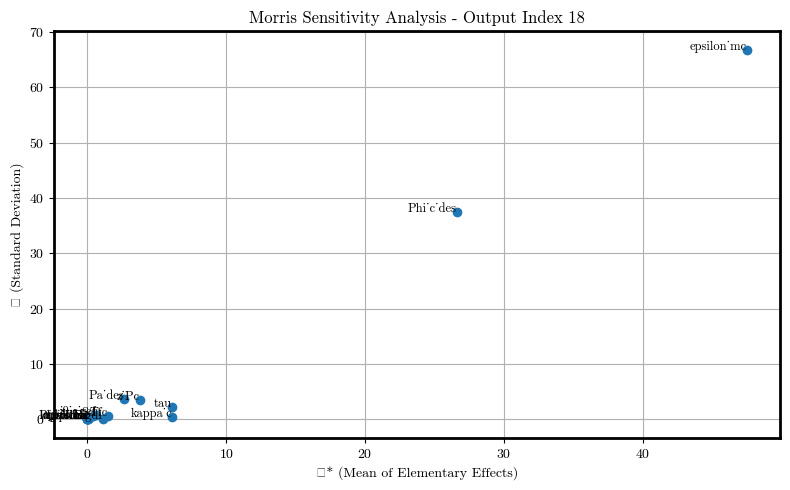

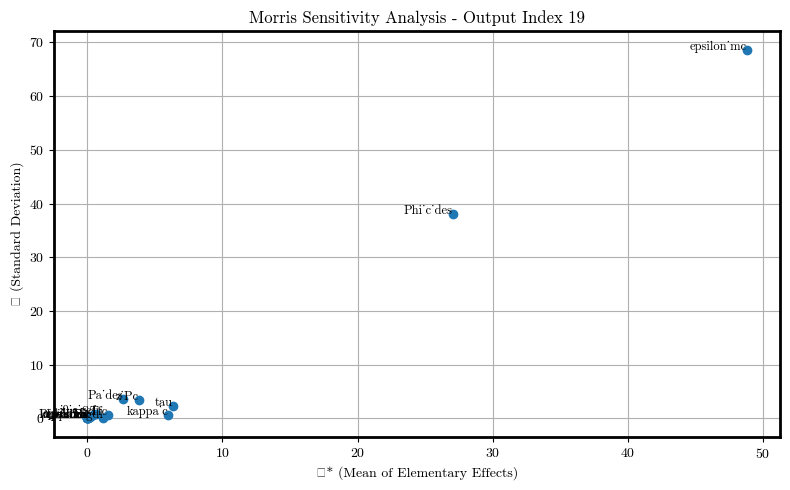

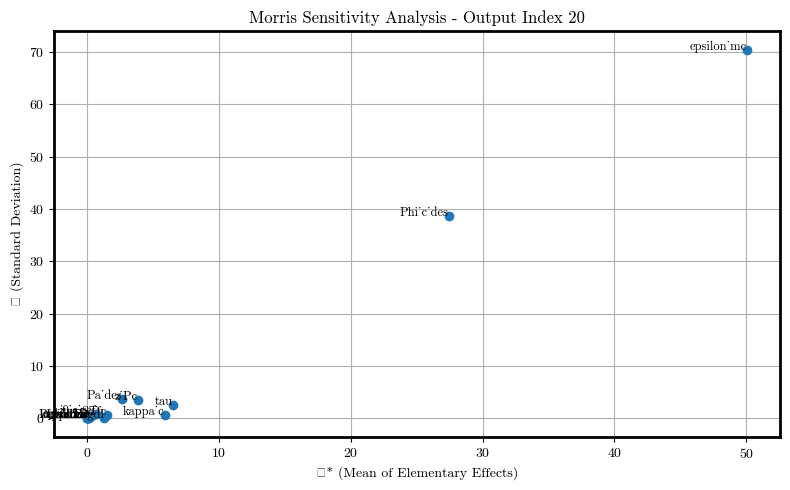

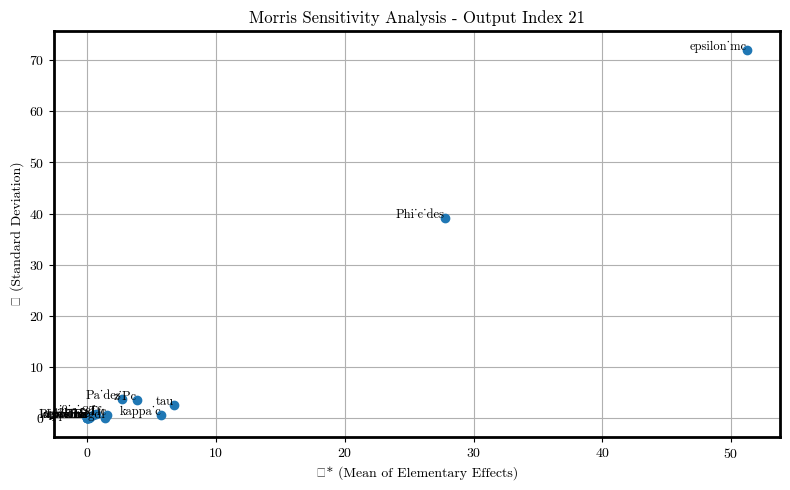

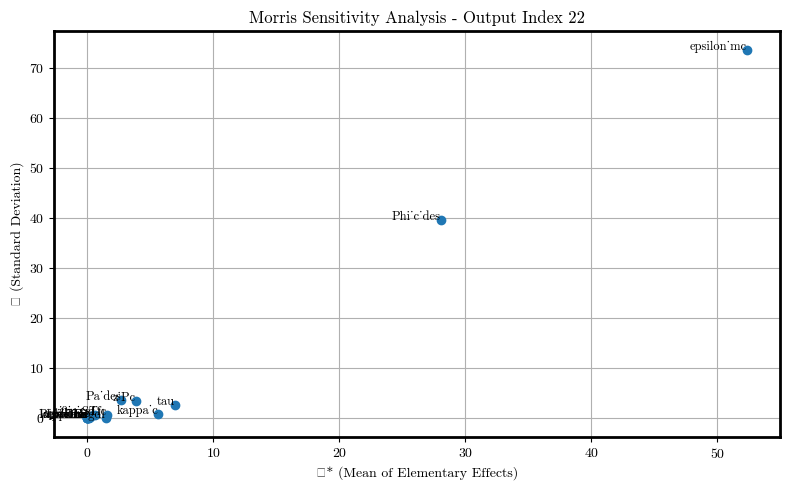

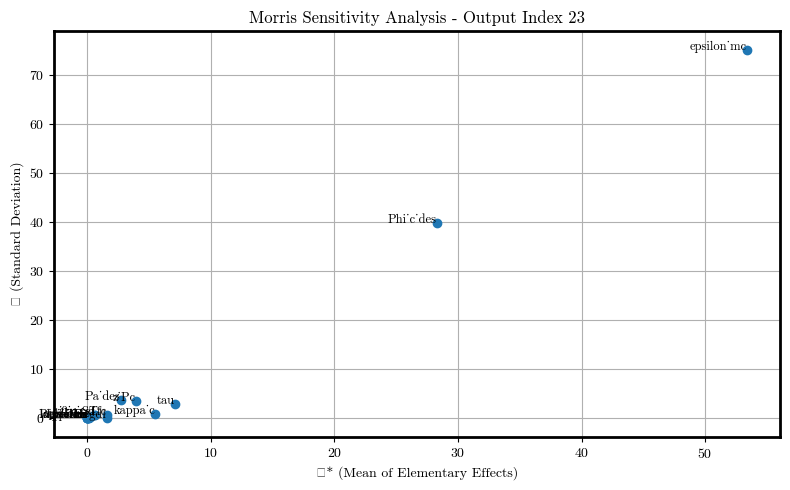

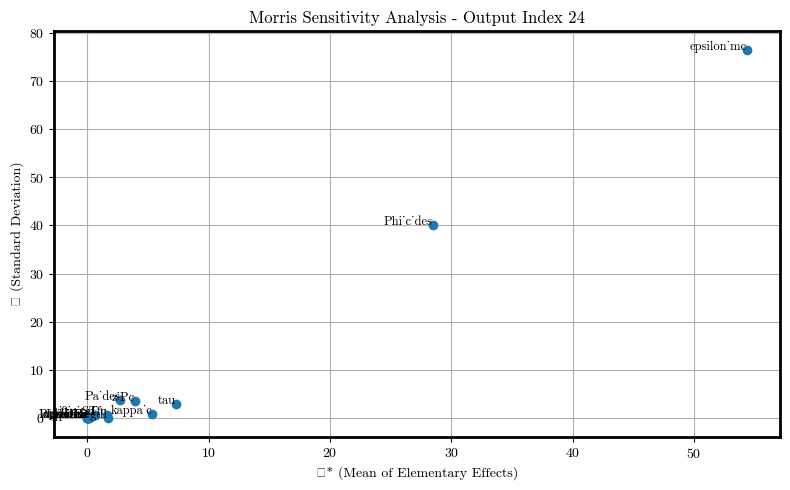

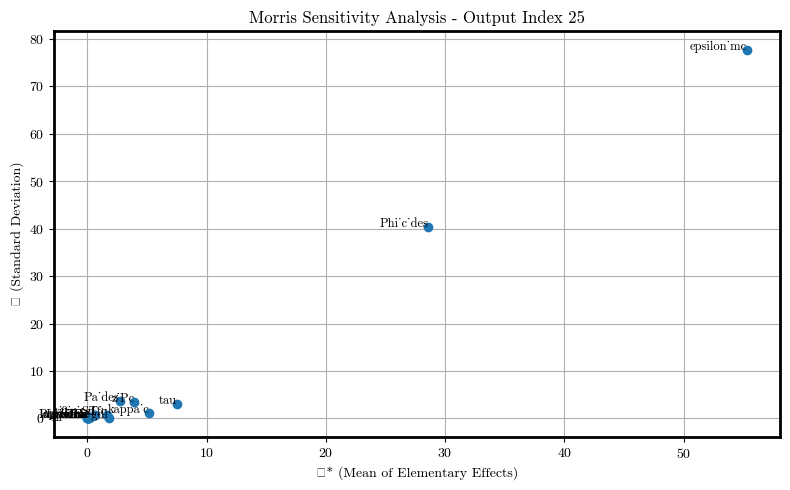

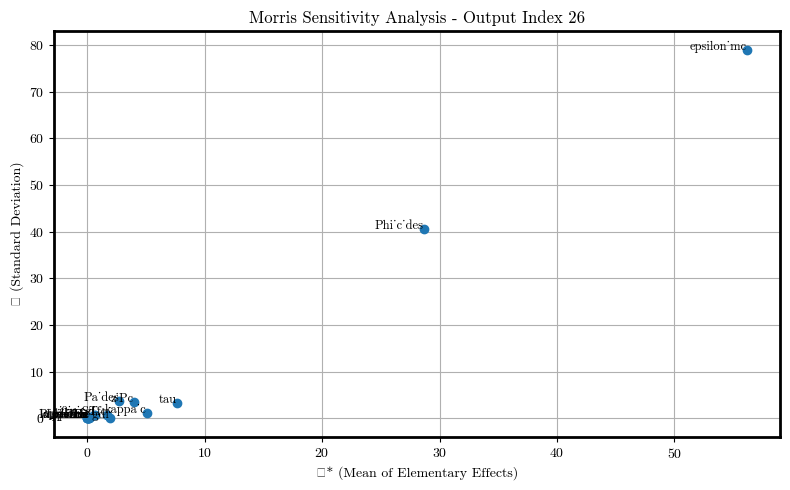

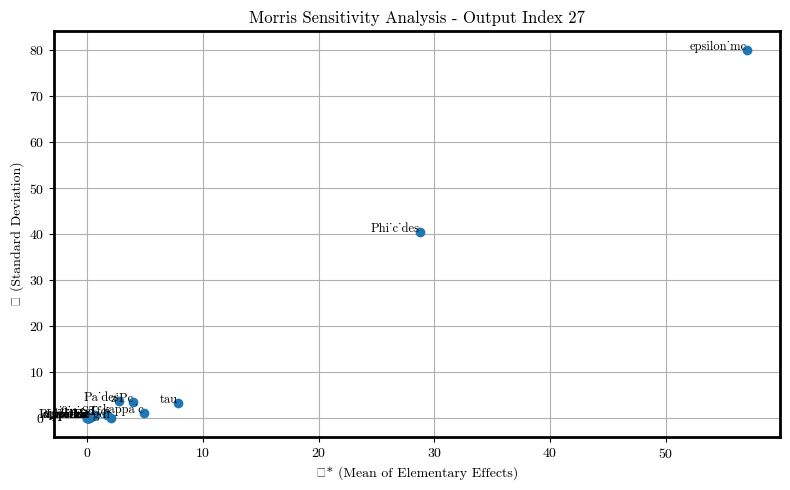

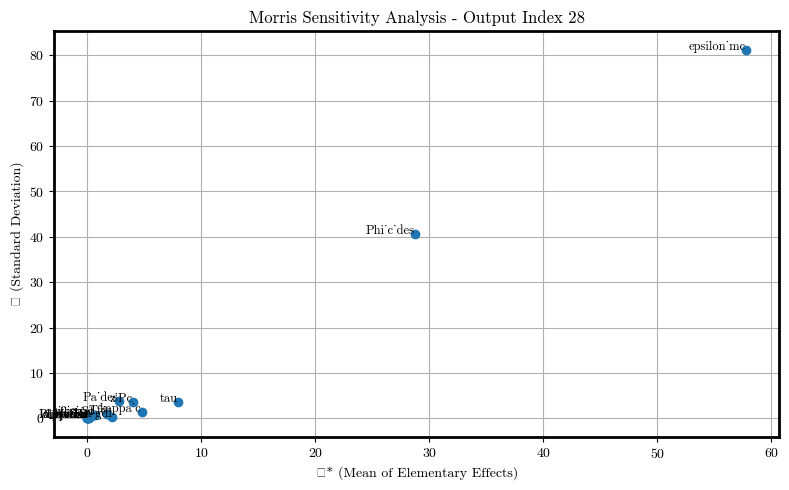

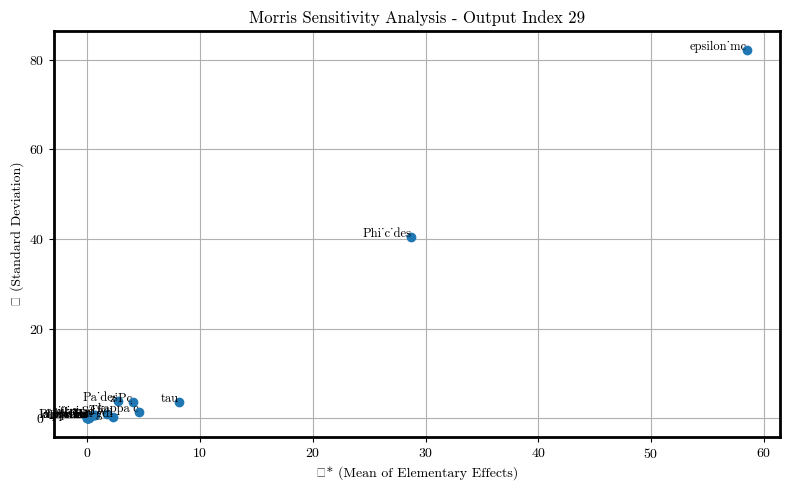

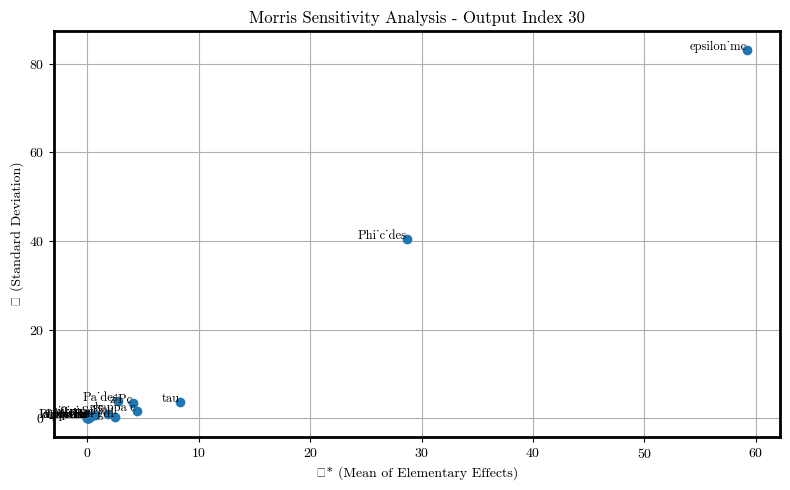

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Number of outputs (points along the polarization curve)
n_outputs = len(morris_all)

# Plot for each output index
for i in range(n_outputs):
    result = morris_all[i]
    mu_star = result['mu_star']
    sigma = result['sigma']
    param_names = result['param']

    plt.figure(figsize=(8, 5))
    plt.errorbar(mu_star, sigma, fmt='o', ecolor='gray', capsize=5)
    for j, param in enumerate(param_names):
        plt.text(mu_star[j], sigma[j], param, fontsize=9, ha='right')

    plt.title(f"Morris Sensitivity Analysis - Output Index {i}")
    plt.xlabel("μ* (Mean of Elementary Effects)")
    plt.ylabel("σ (Standard Deviation)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
